***
## A Query Answering Machine that Predicts the Country from Images

## Final Report
***

## <font color = 'skyblue' size = 5>  **Goal: To classify images of 18 popular cities by country** </font>

<font color = 'steelblue' size = 3> **We will first do some simple setup before getting to the training** </font>


In [3]:
### SET TO FALSE IF NOT RUNNING ON KAGGLE
KAGGLE = True

In [4]:
import os
import skimage
from skimage import io,util,filters
from sklearn.metrics import mean_squared_error, r2_score
from skimage.color import rgb2gray
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
import re
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, Flatten, MaxPool2D, Input

## <font color = 'skyblue' size = 5>  **Loading the data** </font>

<font color='steelblue' size=3><b>To optimize loading time, the data from the previous task has been efficiently stored in a Python pickle object using Shelve. This approach significantly reduces the time required to load images.</b></font>

<font color='steelblue' size=3><b>The stored data is structured as a dictionary, with 'gray' and 'color' fields containing NumPy arrays representing grayscale and color images, respectively.</b></font>

In [5]:
import shelve

shelve_link = '/kaggle/input/images-of-major-capital-cities/small' if KAGGLE else 'small'
d = shelve.open(shelve_link)
print(list(d.keys()))
gray = d['gray']
color = d['color']
labels = d['labels']
num_classes = d['num_classes']
d.close()

['gray', 'color', 'labels', 'num_classes']


## <font color = 'skyblue'>  **Iteration 1** </font>

<font color='steelblue' size=3><b>There are several ideas we can try:</b></font>
<ul>
    <li><font color='steelblue' size=3><b>K-NN with the various image features</b></font></li>
    <li><font color='steelblue' size=3><b>Decision Tree with the various image features</b></font></li>
    <li><font color='steelblue' size=3><b>Bagging</b></font></li>
    <li><font color='steelblue' size=3><b>CNN</b></font></li>
</ul>

<font color='steelblue' size=3><b>For convenience, the features are re-generated here the same way they were in the dataset notebook.</b></font>


### <font color = 'steelblue'> **Model 1: K-NN** </font>

In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

def learn_kNN_classifier(features_data, targets, v=0):
    '''Set up a K-NN classifier and fits it to the given training data.
       Return: learned classifier.''' 
    
    classifier = KNeighborsClassifier(n_neighbors=5, 
                                      weights='uniform')
    parameters_grid = {'n_neighbors': [1, 2, 3, 5, 7, 10, 15] }
    estimator = GridSearchCV(classifier, parameters_grid, verbose=v, 
                             cv=StratifiedKFold(5, shuffle=True), n_jobs=-1)
    estimator.fit(features_data, targets)
    print('Best estimator: {}'.format(estimator.best_estimator_))
    print('Best cross-validated score: {:.3f}'.format(estimator.best_score_))
    print('Score on entire dataset: ', estimator.best_estimator_.score(features_data, targets))

    return estimator.cv_results_, estimator.best_estimator_

<font color='steelblue' size=3><b>This code utilizes GridSearch with 10-fold cross-validation. It iterates over different values of the 'neighbor' parameter, namely [1, 2, 3, 5, 7, 10, 15].</b></font>

#### K-NN with raw grayscale images

In [7]:
# Flattens the images
gray_flattened = gray.reshape(gray.shape[0], gray.shape[1] * gray.shape[2])

In [6]:
results, classifier = learn_kNN_classifier(gray_flattened, labels)

/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

  pid = os.fork()

/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

  pid = os.fork()


Best estimator: KNeighborsClassifier(n_neighbors=1)

Best cross-validated score: 0.244

Score on entire dataset:  0.9996562392574768


<font color='steelblue' size=3><b>While utilizing K-NN with raw grayscale images, the results may not be optimal, especially when GridSearch selects a neighbor value of 1. This performance could be attributed to the primitive nature of the features.</b></font>


#### K-NN Hog Features

In [9]:
from skimage.feature import hog

hogs = [hog(image, orientations=8, pixels_per_cell = (8, 8), cells_per_block = (3, 3), feature_vector=True) for image in tqdm(gray)]
hog_features = np.array(hogs)

100%|██████████| 8727/8727 [01:04<00:00, 134.43it/s]


In [8]:
results, classifier = learn_kNN_classifier(hog_features, labels)

Best estimator: KNeighborsClassifier(n_neighbors=1)

Best cross-validated score: 0.380

Score on entire dataset:  0.9996562392574768


<font color='steelblue' size=3><b>Although the selection of 1 neighbor by GridSearch is concerning, it signifies a significant improvement from using raw images alone.</b></font>


#### K-NN Sift Features

In [10]:
from skimage.filters import gaussian

def get_sift_features(img, max_kp, nfeatures, uhh):

    sift = cv2.SIFT.create(nfeatures=nfeatures, contrastThreshold=0.004)

    img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype('uint8') # type: ignore

    kp_tuple, desc_array = sift.detectAndCompute(img, None) # type: ignore
    
    uhh.append(len(kp_tuple))
    
    if len(kp_tuple) >= max_kp:
        # only use first max_kp keypoints
        kp_tuple = kp_tuple[:max_kp]
        desc_array = desc_array[:max_kp]
    else:
        # fill until max_kp keypoints
        kp_tuple += kp_tuple[-1:] * (max_kp - len(kp_tuple))

        num_repeats = np.ones((desc_array.shape[0], ), dtype=np.int64)
        num_repeats[-1] += max_kp - desc_array.shape[0]

        desc_array = np.repeat(desc_array, num_repeats, axis=0)

    result = []
    for kp, desc in zip(kp_tuple, desc_array):
        result.append(np.concatenate( (np.array(kp.pt), desc) ))

    return np.array(result).flatten()

In [11]:
num_kp = 50

sift_features = np.zeros((len(gray), 130 * num_kp))

uhh = []

for idx, img in tqdm(enumerate(gray)):
    sift_features[idx] = get_sift_features(img, num_kp, 50, uhh)

8727it [00:56, 155.38it/s]


In [51]:
results, classifier = learn_kNN_classifier(sift_features, labels, v=3)

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Best estimator: KNeighborsClassifier(n_neighbors=1)

Best cross-validated score: 0.103

Score on entire dataset:  0.9996562392574768


<font color='steelblue' size=3><b>Due to its very poor performance, SIFT will be dropped in subsequent iterations.</b></font>

#### K-NN Histogram Of Values Features

Uses a histogram of grayscale values for each image

In [12]:
def get_histogram_values(img, nbins=100):

    hist, bins = np.histogram(img, nbins, (0., 1.))

    return hist

In [13]:
hist_features = np.zeros((len(gray), 30))

for idx, img in tqdm(enumerate(gray)):
    hist_features[idx] = get_histogram_values(img, nbins=30)

8727it [00:02, 2928.36it/s]


In [43]:
results, classifier = learn_kNN_classifier(hist_features, labels)

Best estimator: KNeighborsClassifier(n_neighbors=1)

Best cross-validated score: 0.194

Score on entire dataset:  0.710438867881288


<font color='steelblue' size=3><b>Since it performed worse than raw grayscale images, perhaps increasing the bin size could lead to better results?</b></font>


In [22]:
hist_features = np.zeros((len(gray), 5000))

for idx, img in tqdm(enumerate(gray)):
    hist_features[idx] = get_histogram_values(img, nbins=5000)

8727it [00:03, 2398.80it/s]


In [45]:
results, classifier = learn_kNN_classifier(hist_features, labels)

Best estimator: KNeighborsClassifier(n_neighbors=1)

Best cross-validated score: 0.238

Score on entire dataset:  0.9996562392574768


<font color='steelblue' size=3><b>Although an improvement, the performance is still not optimal.</b></font>


#### K-NN Sobel

In [33]:
from skimage.filters import sobel

sobel_features = np.array([sobel(image) for image in gray])

# Flatten the sobel
sobel_features_flat = sobel_features.reshape(sobel_features.shape[0], 128*128)

In [16]:
results, classifier = learn_kNN_classifier(sobel_features_flat, labels)

Best estimator: KNeighborsClassifier(n_neighbors=1)

Best cross-validated score: 0.223

Score on entire dataset:  0.9996562392574768


<font color='steelblue' size=3><b>Not too bad; it could potentially be considered for use in future iterations.</b></font>


#### K-NN with Canny

In [34]:
from skimage.feature import canny

canny_features = np.array([canny(image) for image in gray])

# Flatten the canny
canny_features_flat = canny_features.reshape(canny_features.shape[0], 128*128)

In [18]:
results, classifier = learn_kNN_classifier(canny_features_flat, labels)

Best estimator: KNeighborsClassifier(n_neighbors=1)

Best cross-validated score: 0.158

Score on entire dataset:  0.710438867881288


<font color='steelblue' size=3><b>With its poor performance, it will be dropped in future iterations.</b></font>

***
<font color='steelblue' size=3><b>None of the above models yielded significant results. The highest accuracy reached was 0.38 with HOG features and a K-NN using 1 neighbor. This indicates a need for either improved feature extraction or the exploration of alternative classifier methods.</b></font>


### <font color = 'steelblue'> **Model 2: Decision Trees** </font>

In [19]:
from sklearn.tree import DecisionTreeClassifier

def learn_DT_classifier(features_data, targets, v=3):
    
    classifier = DecisionTreeClassifier(criterion='gini')
    parameters_grid = {'max_depth': [25, 50, 100] }
    estimator = GridSearchCV(classifier, parameters_grid, verbose=v, 
                             cv=StratifiedKFold(3, shuffle=True), n_jobs=-1)
    estimator.fit(features_data, targets)
    print('Best estimator: {}'.format(estimator.best_estimator_))
    print('Best parameters: ', estimator.best_params_)
    print('Best cross-validated score: {:.3f}'.format(estimator.best_score_))
    print('Score on entire dataset: ', estimator.best_estimator_.score(features_data, targets))

    return estimator.cv_results_, estimator.best_estimator_

<font color='steelblue' size=3><b>The code above employs GridSearch to determine the optimal parameters, focusing on the maximum depth of the decision tree.</b></font>

<font color='steelblue' size=3><b>Criterion gini is used to minimize computing time</b></font>

#### Decision Tree with raw grayscale

In [30]:
results, classifier = learn_DT_classifier(gray_flattened, labels)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


[CV 3/3] END ......................max_depth=25;, score=0.123 total time= 4.2min
[CV 1/3] END .....................max_depth=100;, score=0.150 total time= 4.5min
[CV 2/3] END ......................max_depth=25;, score=0.145 total time= 4.1min
[CV 3/3] END ......................max_depth=50;, score=0.146 total time= 4.8min
[CV 1/3] END ......................max_depth=50;, score=0.153 total time= 4.5min
[CV 2/3] END .....................max_depth=100;, score=0.143 total time= 4.5min
Best estimator: DecisionTreeClassifier(max_depth=50)
Best parameters:  {'max_depth': 50}
Best cross-validated score: 0.149
Score on entire dataset:  0.9987395439440816
[CV 1/3] END ......................max_depth=25;, score=0.140 total time= 4.0min
[CV 2/3] END ......................max_depth=50;, score=0.147 total time= 4.7min
[CV 3/3] END .....................max_depth=100;, score=0.142 total time= 3.5min


#### Decision Tree with Hog Features

In [29]:
results, classifier = learn_DT_classifier(hog_features, labels)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


[CV 1/3] END ......................max_depth=25;, score=0.117 total time= 5.2min
[CV 2/3] END ......................max_depth=50;, score=0.132 total time= 6.3min
[CV 2/3] END ......................max_depth=25;, score=0.116 total time= 5.5min
[CV 1/3] END .....................max_depth=100;, score=0.116 total time= 6.1min
[CV 1/3] END ......................max_depth=50;, score=0.118 total time= 6.0min
[CV 2/3] END .....................max_depth=100;, score=0.129 total time= 6.1min
[CV 3/3] END ......................max_depth=25;, score=0.118 total time= 5.4min
[CV 3/3] END ......................max_depth=50;, score=0.125 total time= 6.0min
[CV 3/3] END .....................max_depth=100;, score=0.131 total time= 4.2min
Best estimator: DecisionTreeClassifier(max_depth=100)
Best parameters:  {'max_depth': 100}
Best cross-validated score: 0.125
Score on entire dataset:  0.9996562392574768


#### Decision Tree Sift Features

In [31]:
results, classifier = learn_DT_classifier(sift_features, labels)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best estimator: DecisionTreeClassifier(max_depth=50)
Best parameters:  {'max_depth': 50}
Best cross-validated score: 0.078
Score on entire dataset:  0.9880829609258622


#### Decision Tree Histogram Of Values Features

In [24]:
results, classifier = learn_DT_classifier(hist_features, labels)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best estimator: DecisionTreeClassifier(max_depth=100)
Best parameters:  {'max_depth': 100}
Best cross-validated score: 0.130
Score on entire dataset:  0.9996562392574768


#### Decision with Tree Sobel

In [35]:
results, classifier = learn_DT_classifier(sobel_features_flat, labels)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


[CV 3/3] END ......................max_depth=25;, score=0.116 total time= 5.9min
[CV 2/3] END ......................max_depth=50;, score=0.121 total time= 7.4min
[CV 1/3] END ......................max_depth=50;, score=0.115 total time= 8.7min
[CV 2/3] END .....................max_depth=100;, score=0.126 total time= 7.3min
[CV 1/3] END ......................max_depth=25;, score=0.097 total time= 6.2min
[CV 1/3] END .....................max_depth=100;, score=0.118 total time=10.0min
[CV 2/3] END ......................max_depth=25;, score=0.103 total time= 6.0min
[CV 3/3] END ......................max_depth=50;, score=0.131 total time= 7.3min
[CV 3/3] END .....................max_depth=100;, score=0.130 total time= 5.7min
Best estimator: DecisionTreeClassifier(max_depth=100)
Best parameters:  {'max_depth': 100}
Best cross-validated score: 0.125
Score on entire dataset:  0.983155723616363


#### Decision Tree with Canny

In [36]:
results, classifier = learn_DT_classifier(sobel_features_flat, labels)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


[CV 1/3] END ......................max_depth=25;, score=0.095 total time= 6.1min
[CV 3/3] END ......................max_depth=50;, score=0.129 total time= 7.7min
[CV 3/3] END ......................max_depth=25;, score=0.111 total time= 6.2min
[CV 1/3] END .....................max_depth=100;, score=0.109 total time= 9.0min
[CV 1/3] END ......................max_depth=50;, score=0.112 total time= 8.4min
[CV 2/3] END .....................max_depth=100;, score=0.125 total time= 7.0min
[CV 2/3] END ......................max_depth=25;, score=0.106 total time= 6.0min
[CV 2/3] END ......................max_depth=50;, score=0.125 total time= 7.2min
[CV 3/3] END .....................max_depth=100;, score=0.127 total time= 5.9min
Best estimator: DecisionTreeClassifier(max_depth=50)
Best parameters:  {'max_depth': 50}
Best cross-validated score: 0.122
Score on entire dataset:  0.9091325770596997


<font color='steelblue' size=3><b>The entire decision trees took an extremely long time to run. Certain cells took 30-50 minutes to compute and yielded testing set accuracies ranging from 0.1 to 0.2. Consequently, simple decision trees will not be considered for future use.</b></font>


### <font color = 'steelblue'> **Model 3: Baggin** </font>

<font color='steelblue' size=3><b>We'll explore bagging with k-NN.</b></font>


In [14]:
from sklearn.ensemble import BaggingClassifier

def learn_baggin_classifier(features_data, targets, v=0):
    
    classifier = BaggingClassifier(n_estimators=10)
    parameters_grid = {'estimator': 
                       [KNeighborsClassifier(n_neighbors=1, weights='uniform'),
                       KNeighborsClassifier(n_neighbors=2, weights='uniform'),
                       KNeighborsClassifier(n_neighbors=5, weights='uniform')] }
    
    estimator = GridSearchCV(classifier, parameters_grid, verbose=v, 
                             cv=StratifiedKFold(5, shuffle=True))
    estimator.fit(features_data, targets)
    print('Best estimator: {}'.format(estimator.best_estimator_))
    print('Best parameters: ', estimator.best_params_)
    print('Best cross-validated score: {:.3f}'.format(estimator.best_score_))
    print('Score on entire dataset: ', estimator.best_estimator_.score(features_data, targets))

    return estimator.cv_results_, estimator.best_estimator_

<font color='steelblue' size=3><b>Now, we'll experiment with bagging using k-NN with neighbors 1, 2, and 5. These neighbor values yielded the best results among the primitive k-NN models.</b></font>


#### Bagging with grayscale images

In [19]:
results, classifier = learn_baggin_classifier(gray_flattened, labels)

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Best estimator: BaggingClassifier(estimator=KNeighborsClassifier(n_neighbors=1))

Best parameters:  {'estimator': KNeighborsClassifier(n_neighbors=1)}

Best cross-validated score: 0.229

Score on entire dataset:  0.9361750888048584


<font color='steelblue' size=3><b>This performance is notably lower compared to previous models.</b></font>

#### Bagging with HOG

In [20]:
results, classifier = learn_baggin_classifier(hog_features, labels)

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Best estimator: BaggingClassifier(estimator=KNeighborsClassifier(n_neighbors=1))

Best parameters:  {'estimator': KNeighborsClassifier(n_neighbors=1)}

Best cross-validated score: 0.370

Score on entire dataset:  0.9431648905694969


<font color='steelblue' size=3><b>This perfomed worse than regular K-NN with hog. This could be due to number of estimators being low. However, increasing that increases the running time too much (this alone took 10 minutes)</b></font>

#### Bagging with Histogram features

In [15]:
results, classifier = learn_baggin_classifier(hist_features, labels)

Best estimator: BaggingClassifier(estimator=KNeighborsClassifier(n_neighbors=1))

Best parameters:  {'estimator': KNeighborsClassifier(n_neighbors=1)}

Best cross-validated score: 0.218

Score on entire dataset:  0.932622894465452


<font color='steelblue' size=3><b>Again, perfomed worse than regular K-NN with this, probably for the same reasons</b></font>

#### Bagging with Sobel features

In [16]:
results, classifier = learn_baggin_classifier(sobel_features_flat, labels)

Best estimator: BaggingClassifier(estimator=KNeighborsClassifier(n_neighbors=1))

Best parameters:  {'estimator': KNeighborsClassifier(n_neighbors=1)}

Best cross-validated score: 0.099

Score on entire dataset:  0.9250601581299416


#### Bagging with Sift Features

In [17]:
results, classifier = learn_baggin_classifier(sift_features, labels)

Best estimator: BaggingClassifier(estimator=KNeighborsClassifier(n_neighbors=1))

Best parameters:  {'estimator': KNeighborsClassifier(n_neighbors=1)}

Best cross-validated score: 0.096

Score on entire dataset:  0.9220808983614072



<font color='steelblue' size=3><b>In conclusion, bagging did not significantly improve the results, suggesting it may not be optimal for this task.</b></font>

### <font color = 'steelblue'> **Model 4: CNN** </font>

The CNN will be trained with grayscale images

#### Setting up the CNN layers

In [ ]:
input_shape = (gray[0], gray[1], 1)

CNN_model = Sequential([Input(shape=input_shape),
                        Conv2D(64, kernel_size=(7, 7), activation='leaky_relu'),
                        Conv2D(64, kernel_size=(7, 7), activation='leaky_relu'),
                        Dropout(0.25),
                        MaxPool2D(),
                        Conv2D(32, kernel_size=(7, 7), activation='leaky_relu'),
                        Conv2D(32, kernel_size=(7, 7), activation='leaky_relu'),
                        Dropout(0.25),
                        MaxPool2D(),
                        Conv2D(32, kernel_size=(5, 5), activation='leaky_relu'),
                        Conv2D(32, kernel_size=(5, 5), activation='leaky_relu'),
                        MaxPool2D(),
                        Dropout(0.25),
                        Flatten(),
                        Dense(2048, activation='leaky_relu'),
                        Dense(1024, activation='leaky_relu'),
                        Dropout(0.3),
                        Dense(512, activation='leaky_relu'),
                        Dense(256, activation='leaky_relu'),
                        Dropout(0.3),
                        Dense(128, activation='leaky_relu'),
                        Dense(num_classes, activation='softmax')
                        ])

CNN_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
CNN_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 122, 122, 64)   │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 116, 116, 64)   │       200,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 116, 116, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 58, 58, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 32)     │       100,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 46, 46, 32)     │        50,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 46, 46, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 19, 19, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 15, 15, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │     3,213,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 18)             │         2,322 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,408,658 (24.45 MB)

 Trainable params: 6,408,658 (24.45 MB)

 Non-trainable params: 0 (0.00 B)

#### Training the CNN

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(new_grayscale_images, labels, test_size=0.05, shuffle=True)

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((8290, 128, 128), (437, 128, 128), (8290,), (437,))

In [ ]:
num_validation = int(0.3 * X_test.shape[0])
batches = 128
num_epochs = 20

training = CNN_model.fit(X_train, Y_train,
                         batch_size=batches,
                         epochs=num_epochs,
                         validation_data=(X_test[:num_validation],
                                          Y_test[:num_validation]))

score = CNN_model.evaluate(X_test, Y_test, verbose=0)

print('Test score: ', score[0])
print('Test accuracy: ', score[1])

Epoch 1/20


2024-04-25 22:42:41.275386: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng11{k2=1,k3=0} for conv (f32[128,64,116,116]{3,2,1,0}, u8[0]{0}) custom-call(f32[128,64,122,122]{3,2,1,0}, f32[64,64,7,7]{3,2,1,0}, f32[64]{0}), window={size=7x7}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-04-25 22:42:41.834652: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.559403292s
Trying algorithm eng11{k2=1,k3=0} for conv (f32[128,64,116,116]{3,2,1,0}, u8[0]{0}) custom-call(f32[128,64,122,122]{3,2,1,0}, f32[64,64,7,7]{3,2,1,0}, f32[64]{0}), window={size=7x7}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2

64/65 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.0551 - loss: 2.9106

2024-04-25 22:44:20.742569: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng11{k2=1,k3=0} for conv (f32[98,64,116,116]{3,2,1,0}, u8[0]{0}) custom-call(f32[98,64,122,122]{3,2,1,0}, f32[64,64,7,7]{3,2,1,0}, f32[64]{0}), window={size=7x7}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-04-25 22:44:20.975532: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.23308249s
Trying algorithm eng11{k2=1,k3=0} for conv (f32[98,64,116,116]{3,2,1,0}, u8[0]{0}) custom-call(f32[98,64,122,122]{3,2,1,0}, f32[64,64,7,7]{3,2,1,0}, f32[64]{0}), window={size=7x7}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-0

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0551 - loss: 2.9105   

W0000 00:00:1714085117.685337     148 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


65/65 ━━━━━━━━━━━━━━━━━━━━ 173s 1s/step - accuracy: 0.0551 - loss: 2.9104 - val_accuracy: 0.0611 - val_loss: 2.8884
Epoch 2/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 22s 337ms/step - accuracy: 0.0584 - loss: 2.8914 - val_accuracy: 0.0534 - val_loss: 2.8957
Epoch 3/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 22s 338ms/step - accuracy: 0.0569 - loss: 2.8902 - val_accuracy: 0.0382 - val_loss: 2.8989
Epoch 4/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 22s 339ms/step - accuracy: 0.0554 - loss: 2.8911 - val_accuracy: 0.0611 - val_loss: 2.8917
Epoch 5/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 22s 341ms/step - accuracy: 0.0595 - loss: 40.8005 - val_accuracy: 0.0534 - val_loss: 13710.9287
Epoch 6/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 22s 341ms/step - accuracy: 0.0567 - loss: 871.2939 - val_accuracy: 0.0534 - val_loss: 634.2735
Epoch 7/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 22s 341ms/step - accuracy: 0.0584 - loss: 307.0118 - val_accuracy: 0.0382 - val_loss: 176.3484
Epoch 8/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 22s 342ms/step - accuracy: 0.0530 - loss: 6.5303 - val_accu

W0000 00:00:1714085554.320320     148 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Test score:  21.212190628051758
Test accuracy:  0.06178489699959755


W0000 00:00:1714085562.773560     148 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


#### Visualizing CNN Outputs

In [ ]:
def show_learning_curves(learning_evolution, title=''):

    # list all data stored in the learning_evolution object
    print('Stored information:', [h for h in learning_evolution.history.keys()])

    # show evolution of accuracy
    plt.plot(learning_evolution.history['accuracy'])

    # show evolution of cross-validated accuracy
    if 'val_accuracy' in learning_evolution.history:
        plt.plot(learning_evolution.history['val_accuracy'])

    plt.title(title + 'Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')

    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # show evolution of loss
    plt.plot(learning_evolution.history['loss'])
    
     # show evolution of cross-validated loss
    if 'val_accuracy' in learning_evolution.history:
        plt.plot(learning_evolution.history['val_loss'])

    plt.title(title + 'Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

Stored information: ['accuracy', 'loss', 'val_accuracy', 'val_loss']


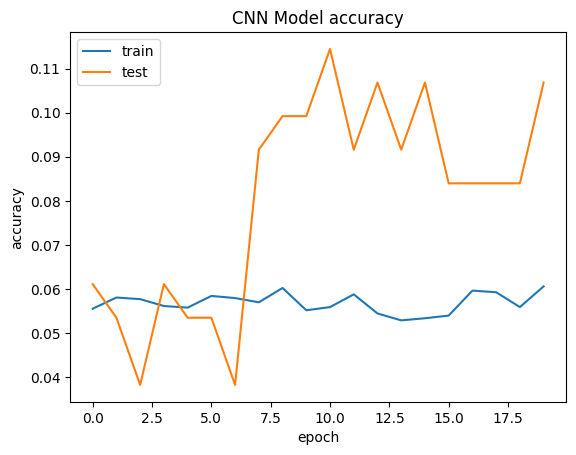

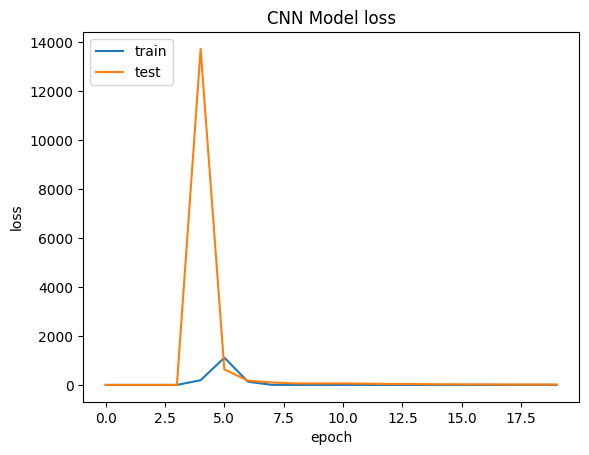

In [ ]:
show_learning_curves(training, 'CNN ')

In [ ]:
from keras.models import Model

def display_activation(activations, activation_index, ncols=5, size=(12, 12), reshape=None):

    activation = activations[activation_index]

    print('Shape of layer: ', activation.shape)

    if len(activation.shape) > 2:
        total_fmaps = activation.shape[-1] # the last axis of the array
        nrows = int(np.ceil(total_fmaps / ncols))
    else:
        total_fmaps = 1
        nrows,ncols = (1,1)

    feature_map=0

    if (ncols, nrows) == (1,1):
        plt.yticks([], [])
        plt.xticks(fontsize=6)
        if reshape == None:
            plt.imshow(activation[0].reshape(-1,1).T)
        else:
            plt.imshow(activation[0].reshape(reshape).T)
        plt.show()
        return

    fig = plt.figure(figsize=size)
    fig.subplots_adjust(hspace=0.23, wspace=0.22)

    for row in range(nrows):
        for col in range(ncols):
            subplot = fig.add_subplot(nrows, ncols, feature_map+1)
            #subplot[row][col].imshow(activation[0, :, :, feature_map],
            #                         cmap='gray')
            #subplot[row][col].tick_params(labelsize = 3)
            subplot.imshow(activation[0, :, :, feature_map])# cmap='gray')
            subplot.tick_params(labelsize = 3)

            feature_map += 1
            if feature_map == total_fmaps:
                plt.show()
                return

In [ ]:
layer_outputs = [layer.output for layer in CNN_model.layers]

layer_names = [layer.name.split('_')[0] for layer in CNN_model.layers]

activation_model = Model(inputs=CNN_model.layers[0].input, outputs=layer_outputs)

sample_idx = 1324
img_sample = new_grayscale_images[sample_idx].reshape((1, *input_shape))

activations = activation_model.predict(img_sample)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


'label: 2'

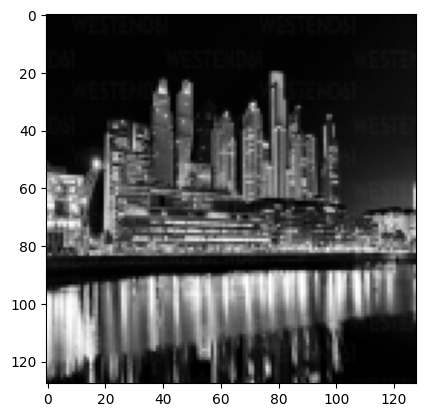

In [ ]:
plt.imshow(new_grayscale_images[sample_idx], cmap='gray')
f'label: {labels[sample_idx]}'

Type of layer:  conv2d
Shape of layer:  (1, 122, 122, 64)


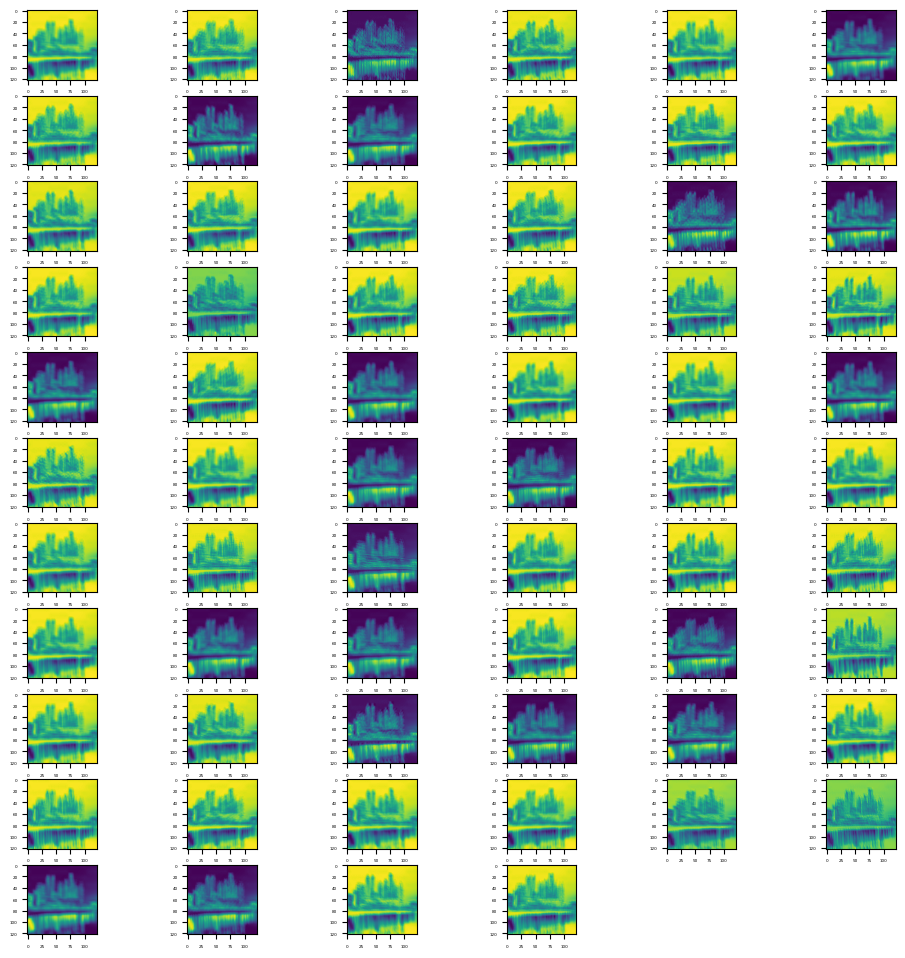

Type of layer:  conv2d
Shape of layer:  (1, 116, 116, 64)


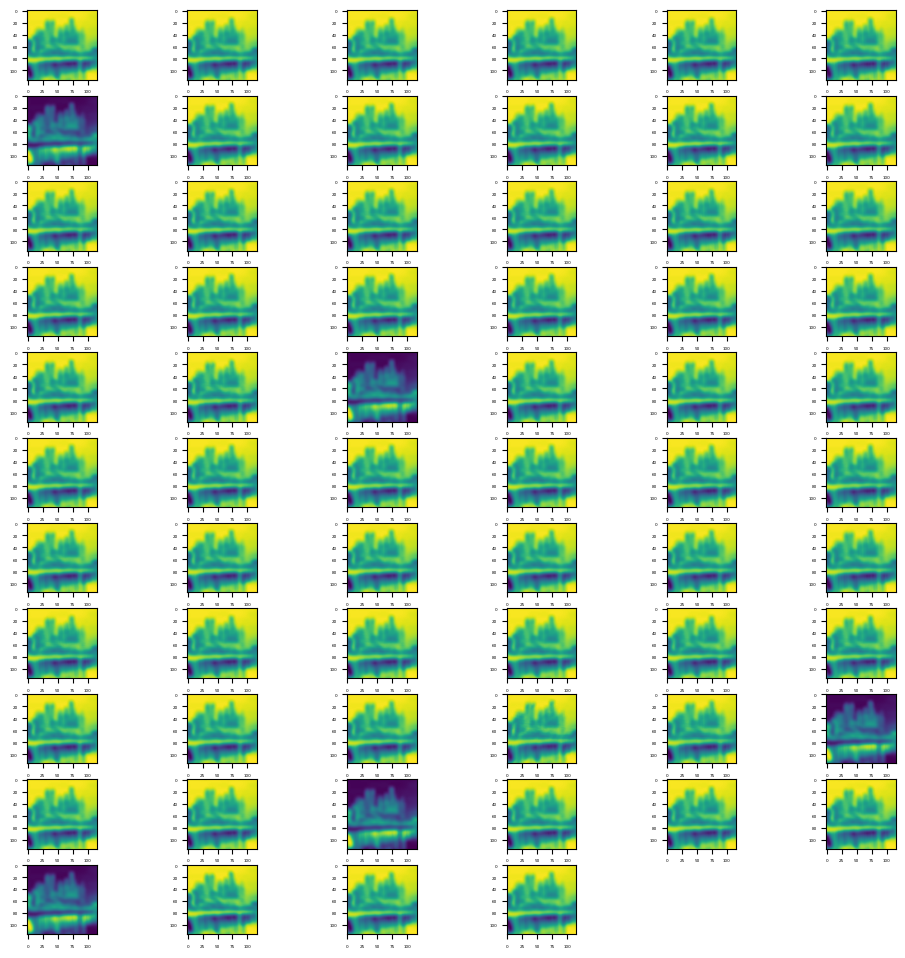

Type of layer:  dropout
Type of layer:  max
Type of layer:  conv2d
Shape of layer:  (1, 52, 52, 32)


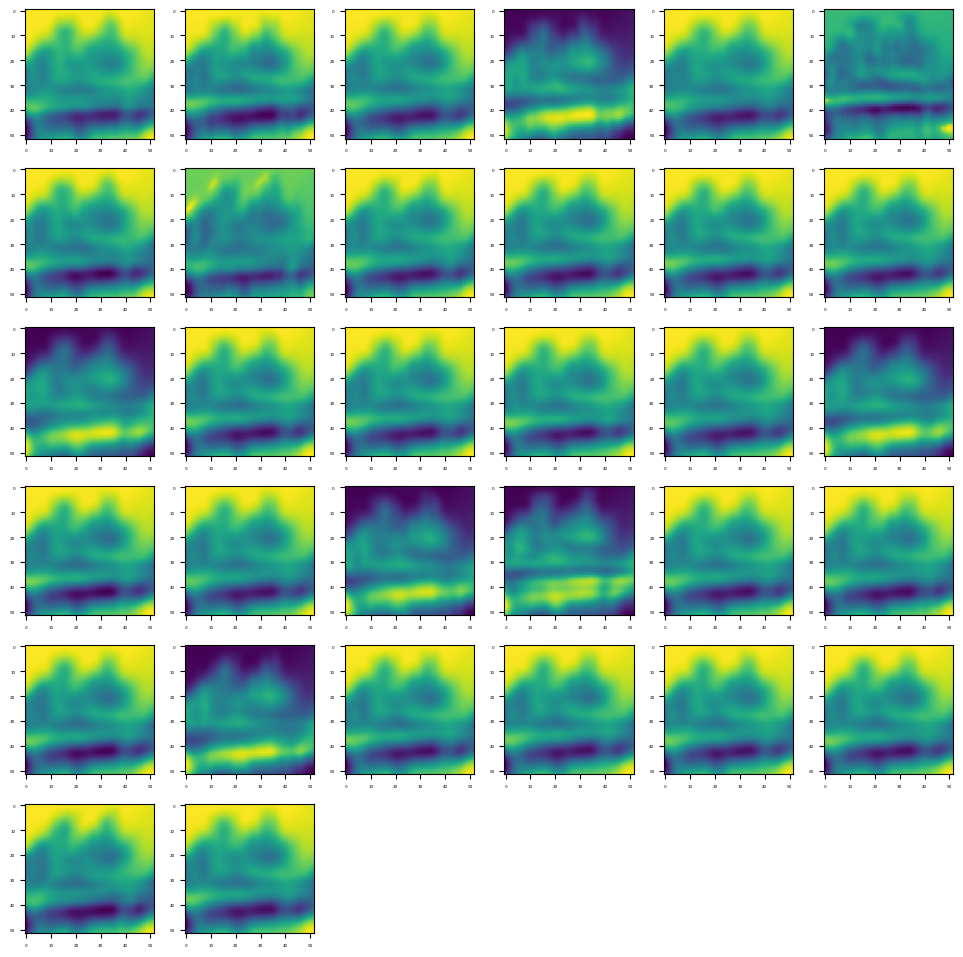

Type of layer:  conv2d
Shape of layer:  (1, 46, 46, 32)


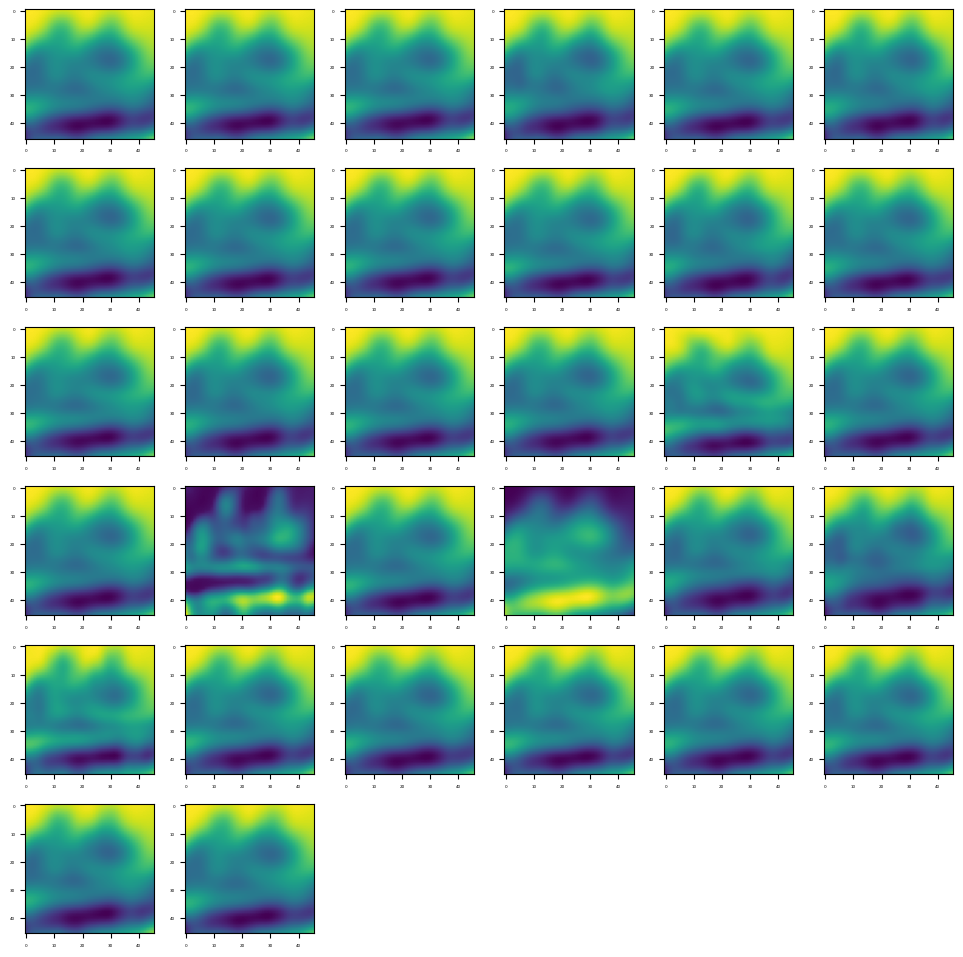

Type of layer:  dropout
Type of layer:  max
Type of layer:  conv2d
Shape of layer:  (1, 19, 19, 32)


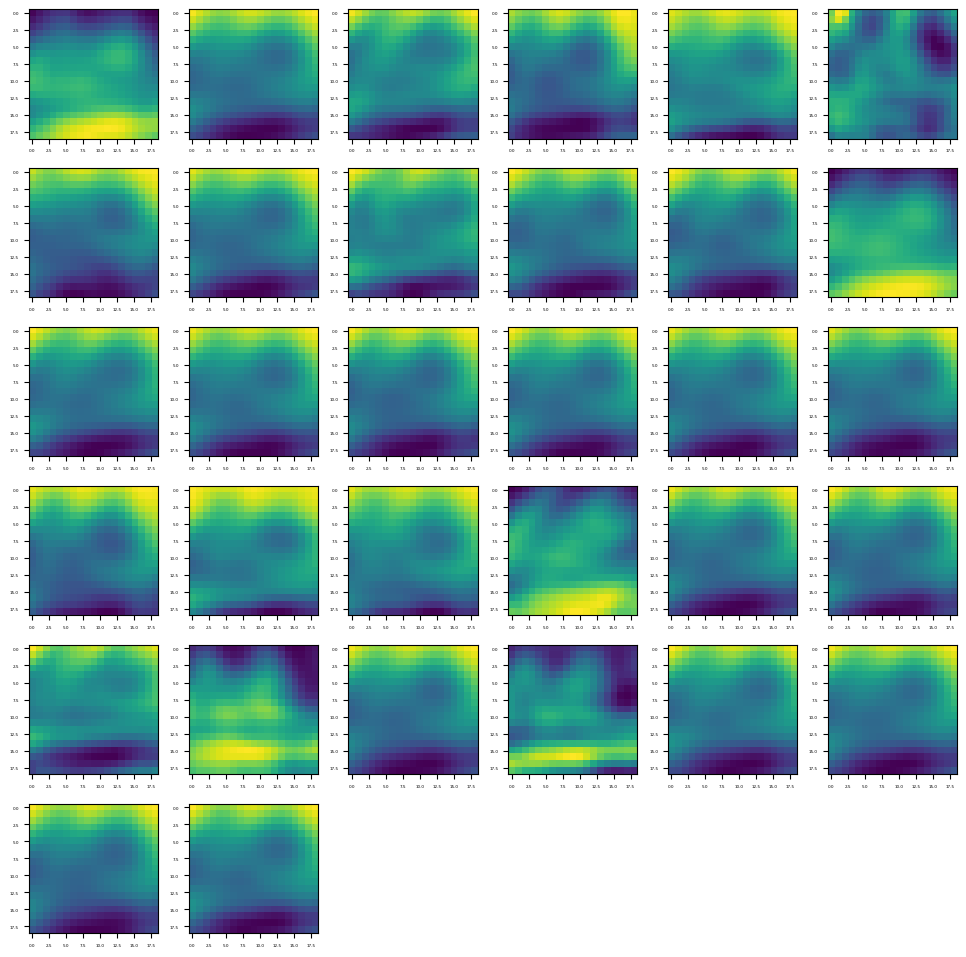

Type of layer:  conv2d
Shape of layer:  (1, 15, 15, 32)


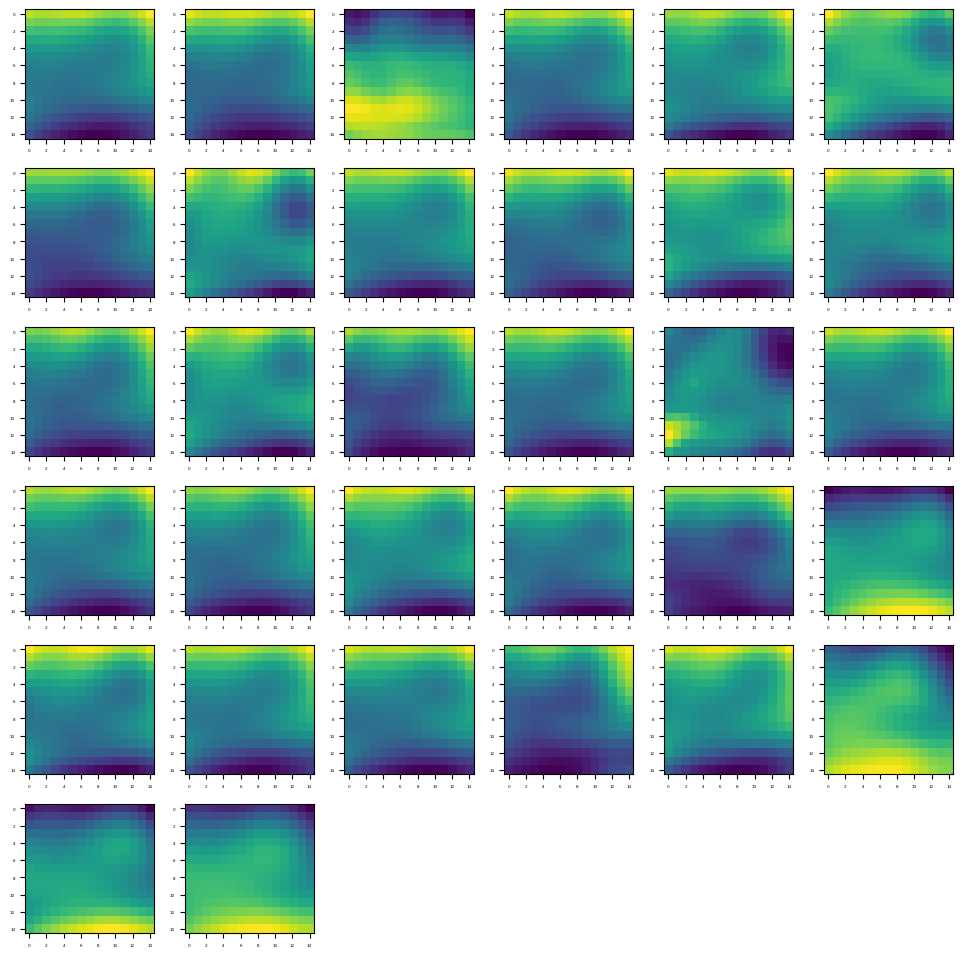

Type of layer:  max
Type of layer:  dropout
Type of layer:  flatten
Type of layer:  dense
Type of layer:  dense
Type of layer:  dropout
Type of layer:  dense
Type of layer:  dense
Type of layer:  dropout
Type of layer:  dense
Type of layer:  dense


In [ ]:
for i in range(len(layer_names)):
    print('Type of layer: ', layer_names[i])
    if layer_names[i] == 'conv2d':
        display_activation(activations, i, 6)

Shape of layer:  (1, 2048)


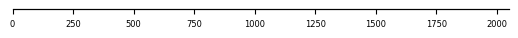

Shape of layer:  (1, 1024)


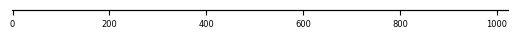

Shape of layer:  (1, 512)


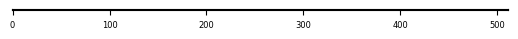

Shape of layer:  (1, 256)


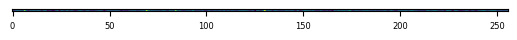

Shape of layer:  (1, 128)


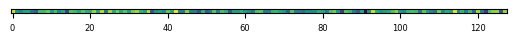

Shape of layer:  (1, 18)


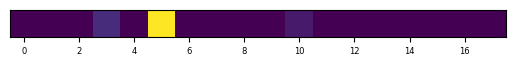

In [ ]:
for i in range(len(layer_names)):
    if layer_names[i] == 'dense':
        display_activation(activations, i, 1)

### <font color = 'steelblue'> **Model 5: Support Verctor Machines** </font>

<font color='steelblue' size=3><b>Next, we will explore Support Vector Machines (SVM) with linear, RBF, and polynomial kernels to determine which one yields the best performance.</b></font>


In [37]:
from sklearn import svm
from sklearn.model_selection import train_test_split

def learn_SVM_classifier(features_data, targets, kernel):
    
    X_train, X_test, Y_train, Y_test = train_test_split(features_data, targets, 
                                                        test_size=0.3, 
                                                        shuffle=True, stratify=targets)

    classifier = svm.SVC(kernel = kernel)
    
    classifier.fit(X_train, Y_train)
    print("Done traininging!")
    print('Training score:', classifier.score(X_train, Y_train))
    print('Testing score:', classifier.score(X_test, Y_test))

    return classifier

#### SVM on raw grayscale

In [41]:
# Linear
classifier = learn_SVM_classifier(gray_flattened, labels,'linear')

Training score: 0.7135080933963616

Testing score: 0.1981672394043528


In [42]:
# Poly
classifier = learn_SVM_classifier(gray_flattened, labels,'poly')

Training score: 0.6603638447213867

Testing score: 0.1764032073310424


In [38]:
# RBF
classifier = learn_SVM_classifier(gray_flattened, labels,'rbf')

Done traininging!
Training score: 0.30861165684348396
Testing score: 0.14165712103856434


<font color='steelblue' size=3>**Training the SVM took an exceptionally long time, indicating potential inefficiencies in the training process. Also, the accuracy achieved by the SVM model is unsatisfactor**</font>


***
<font color='steelblue' size=3>**The cells below do not have output since they would take a very long time to run**</font>


#### SVM on HOG

In [ ]:
# Linear
classifier = learn_SVM_classifier(hog_features, labels,'linear')

In [ ]:
# Poly
classifier = learn_SVM_classifier(hog_features, labels,'poly')

In [ ]:
# RBF
classifier = learn_SVM_classifier(hog_features, labels,'rbf')

#### SVM on histogram features

In [ ]:
# Linear
classifier = learn_SVM_classifier(hist_features, labels,'linear')

In [ ]:
# Poly
classifier = learn_SVM_classifier(hist_features, labels,'poly')

In [ ]:
# RBF
classifier = learn_SVM_classifier(hist_features, labels,'rbf')

### <font color = 'steelblue'> **Analysis** </font>

#### Solution and Justification:
We explored K-NN, Decision Trees, Bagging, CNN, and SVM for classifying city views. These models were chosen for their potential effectiveness with image data.

#### Solution Details:
1. **K-NN:** Used for its simplicity. Performance varied with different features.
   
2. **Decision Trees:** Showed promise but had long computation times.
   
3. **Bagging:** Did not significantly improve K-NN results.
   
4. **CNN:** Computationally expensive with grayscale images.
   
5. **SVM:** Long training times and unsatisfactory accuracy.

#### Lessons Learnt:
- K-NN accuracy varied with features.
- Decision Trees had long computation times.
- Bagging did not improve K-NN.
- CNN training was computationally expensive.
- SVM had long training times and low accuracy.

Further experimentation needed for better accuracy.


## <font color = 'skyblue'>  **Iteration 2** </font>

For this iteration we will try:
1. A K-NN with the best features combines from previous iterations
3. An SVM with the best features combines from previous iterations
3. Boosting decision stump (AdaBoost)
4. CNN with rgb images

We will not be using simple decision trees or random forest due to the already large computation time of decision tree and low accuracy.

### <font color = 'steelblue'> **Model 1: K-NN with combined features** </font>

From the previous iterations, the best features for a K-NN turned out to be raw grayscale, HOG and Sobel. We will combine these features and pass them to the K-NN

In [16]:
combined_features = np.concatenate((gray_flattened, hog_features, sobel_features_flat), axis=1)

It would be better to normalize the features since they come from different types

In [17]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
combined_features_normalized = scaler.fit_transform(combined_features)

In [18]:
results, classifier = learn_kNN_classifier(combined_features_normalized, labels, v=1)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best estimator: KNeighborsClassifier(n_neighbors=1)
Best cross-validated score: 0.274
Score on entire dataset:  0.9996562392574768


This perfomed worse than sandalone HOG features

### <font color = 'steelblue'> **Model 2: SVM with combined features** </font>

In [ ]:
results, classifier = learn_SVM_classifier(combined_features_normalized, labels, v=3)

### <font color = 'steelblue'> **Model 3: Boosting decision stump (AdaBoost)** </font>

In [22]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

def learn_boosting_classifier(features_data, targets, v=1):
    
    classifier = AdaBoostClassifier(n_estimators=50, learning_rate=1.0)
    parameters_grid = {'base_estimator': [DecisionTreeClassifier(max_depth=1)] }
    
    estimator = GridSearchCV(classifier, parameters_grid, verbose=v, 
                             cv=StratifiedKFold(5, shuffle=True))
    estimator.fit(features_data, targets)
    print('Best estimator: {}'.format(estimator.best_estimator_))
    print('Best parameters: ', estimator.best_params_)
    print('Best cross-validated score: {:.3f}'.format(estimator.best_score_))
    print('Score on entire dataset: ', estimator.best_estimator_.score(features_data, targets))

    return estimator.cv_results_, estimator.best_estimator_

In [ ]:
results, classifier = learn_boosting_classifier(hog_features, labels, v=3)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/5] END base_estimator=DecisionTreeClassifier(max_depth=1);, score=0.126 total time=15.4min


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


### <font color = 'steelblue'> **Model 4: CNN with rgb images** </font>

Using raw grayscale images turned out not to be successful in the previous iteration. As such, we will try to train our CNN model on the rbg images. 

We will also change the architecture of the CNN to accept larger images and end up with a larger image at the end of the convolutional layers. We also decrease the number of dense layers

### <font color = 'steelblue'> **Analysis** </font>

#### Solution and Justification:
For this iteration, we opted for a combination of K-NN, AdaBoost (boosting decision stumps), and a CNN model trained on RGB images. Decision trees and random forests were excluded due to their computational demands and low accuracy.


#### Solution Details:
1. **K-NN with Combined Features**: Combined raw grayscale, HOG, and Sobel features, normalized for improved performance, resulting in a cross-validated score of 0.274, notably worse than standalone HOG features.
   
2. **Boosting Decision Stump - AdaBoost**: Utilized AdaBoost with decision tree stumps, achieving a cross-validated score of 0.126, with a total fitting time of 15.4 minutes.
   
3. **CNN with RGB Images**: Transitioned from grayscale to RGB images and adjusted CNN architecture to handle larger images with reduced dense layers.

#### Lessons Learnt:
- Combined features in K-NN did not yield satisfactory results compared to standalone HOG features.
- AdaBoost with decision stumps showed limited improvement in accuracy.
- Transitioning to RGB images in the CNN model may lead to better performance, but further adjustments to architecture and training strategy are required.
- A CNN seems to be the most promising 


## <font color = 'skyblue'>  **Iteration 3** </font>

For this iteration, we will work on improving the CNN as the previous models did not work well. To do that, we will utilize pretrained CNN models and free the weights for the layers that were pretrained, adding our own dense layers afterwards. 

We will run several pretrained models and select the best one

### <font color = 'steelblue'> **Model 1: ResNet** </font>

### <font color = 'steelblue'> **Model 2: ResNet** </font>

### <font color = 'steelblue'> **Model 3: ConvNext** </font>